In [8]:
%pip install numpy pandas seaborn matplotlib 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
import subprocess

num_steps_users = 12  # Number of steps for users
num_steps_sizes = 12  # Number of steps for payload sizes
run_time_seconds = 30  # Number of seconds to run each test
num_workers = 4 # Number of workers to use for each test

#num_users_list = np.array([20])
num_users_list = np.unique(np.logspace(0, 8, num=num_steps_sizes, base=2).astype(int))  # Logarithmically spaced sizes, ensure unique values
payload_sizes = np.unique(np.logspace(0, 20, num=num_steps_sizes, base=2).astype(int))  # Logarithmically spaced sizes, ensure unique values


# fix user, small files between 1byte and 100kb
#min_size_log2 = 0  # log2(1 byte)
#max_size_log2 = log(100 * 1024, 2)  # log2(100 KB)
#num_steps_sizes = 32  # Number of steps for payload sizes
#payload_sizes = np.unique(np.logspace(min_size_log2, max_size_log2, num=num_steps_sizes, base=2).astype(int))
#num_users_list = np.full(1, 500)

In [35]:

tasks = []
for payload_size in payload_sizes:
    for num_users in num_users_list:
        task = {
            "num_users": num_users,
            "spawn_rate": num_users,  # Adjust as needed
            "payload_size": payload_size,
            "csv_filename": f"results_{payload_size}_{num_users}"
        }
        tasks.append(task)

# View first 5 tasks as an example
tasks_df = pd.DataFrame(tasks)

pd.set_option('display.max_rows', None)
print(tasks_df)
pd.reset_option('display.max_rows')


     num_users  spawn_rate  payload_size         csv_filename
0            1           1             1          results_1_1
1            2           2             1          results_1_2
2            4           4             1          results_1_4
3            7           7             1          results_1_7
4           12          12             1         results_1_12
5           20          20             1         results_1_20
6           34          34             1         results_1_34
7           56          56             1         results_1_56
8           93          93             1         results_1_93
9          154         154             1        results_1_154
10         256         256             1        results_1_256
11           1           1             3          results_3_1
12           2           2             3          results_3_2
13           4           4             3          results_3_4
14           7           7             3          results_3_7
15      

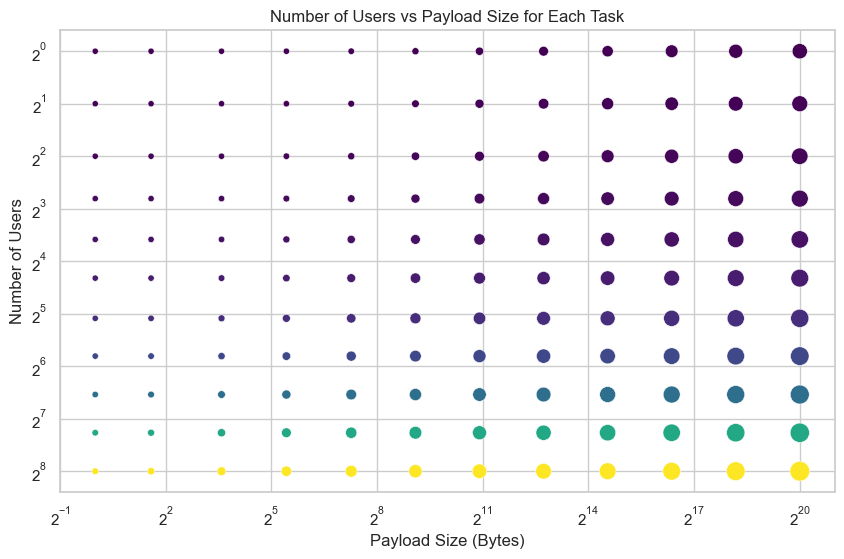

In [44]:
tasks_df['size_metric'] = tasks_df['num_users'] * tasks_df['payload_size'] / 1024
tasks_df['log_size_metric'] = np.log2(tasks_df['size_metric'] + 1)

# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=tasks_df, x='payload_size', y='num_users', size='log_size_metric', hue='num_users', palette='viridis', sizes=(20, 200), legend=False)

# Set the scale of the x/y-axis to logarithmic to better visualize the data
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)

ax.invert_yaxis()

# Set plot labels and title
ax.set_xlabel('Payload Size (Bytes)')
ax.set_ylabel('Number of Users')
ax.set_title('Number of Users vs Payload Size for Each Task')

# Show the plot
plt.show()

In [12]:
def run_benchmark_docker(task):
    results_file_path = f"results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f".{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    # Set environment variables
    os.environ['NUM_USERS'] = str(task['num_users'])
    os.environ['SPAWN_RATE'] = str(task['spawn_rate'])
    os.environ['RUN_TIME'] = str(run_time_seconds)
    os.environ['CSV_FILENAME'] = results_file_path
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Run the benchmark using Docker Compose
    subprocess.run(["docker", "compose", "up", "--scale", f"locust-worker={num_workers}"], check=True)

    # Optionally, you can stop and remove containers if needed
    subprocess.run(["docker-compose", "down"], check=True)


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

#for task in tasks:
#    run_benchmark_docker(task)

In [13]:
def run_benchmark_local(task):
    results_file_path = f".results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f"{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Command to start the Locust master
    master_command = ["locust", "-f", "../locust/locustfile.py", "--master", "--headless", 
                      "--expect-workers", "4",
                      "--host", "http://192.168.1.105:8000", 
                      "-u", str(task['num_users']), 
                      "-r", str(task['spawn_rate']), 
                      "--run-time", str(run_time_seconds),
                      "--csv", results_file_path]

    # Commands to start Locust workers
    worker_commands = [
        ["locust", "-f", "../locust/locustfile.py", "--worker", "--master-host", "127.0.0.1"] for _ in range(num_workers)
    ]

    # Start the Locust master
    master_process = subprocess.Popen(master_command)

    # Start the worker processes
    worker_processes = [subprocess.Popen(cmd) for cmd in worker_commands]
    
    try:
        # Wait for the master process to complete
        master_process.wait()
    except KeyboardInterrupt:
        # Handle Ctrl+C
        pass
    finally:
        # Terminate all processes
        master_process.terminate()
        for worker in worker_processes:
            worker.terminate()


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

for task in tasks:
    run_benchmark_local(task)

payload_size: 1
payload_size: 1
payload_size: 1
payload_size: 1
payload_size: 1


[2023-11-14 23:17:08,745] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:17:08,747] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_91e707c3b43647849f73a4ffe9d68e00 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:17:08,748] BUD-MAC-16300-(27107)/INFO/locust.main:

payload_size: 3
payload_size: 3
payload_size: 3
payload_size: 3
payload_size: 3


[2023-11-14 23:17:41,899] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:17:41,902] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_b77bf6f91f984affaa6fd908067a745b (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:17:41,903] BUD-MAC-16300-(27107)/INFO/locust.runne

payload_size: 6payload_size: 6

payload_size: 6
payload_size: 6
payload_size: 6


[2023-11-14 23:18:15,060] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:18:15,062] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_9db5e79dddda476da7178df82a64f2e6 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:18:15,063] BUD-MAC-16300-(27107)/INFO/locust.main:

payload_size: 11payload_size: 11

payload_size: 11
payload_size: 11
payload_size: 11


[2023-11-14 23:18:48,273] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:18:48,275] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_207c833d36d2451a9376b99800a4eb9b (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:18:48,275] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_8fef9e1864ce48159be204e7466e0245 (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 20payload_size: 20

payload_size: 20
payload_size: 20
payload_size: 20


[2023-11-14 23:19:21,438] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:19:21,440] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_7d84a4ce4c904f7ebf370566d70c7dd8 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:19:21,440] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_89a04817af244f3bb8c5138932493243 (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 37
payload_size: 37
payload_size: 37
payload_size: 37
payload_size: 37


[2023-11-14 23:19:54,617] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:19:54,620] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_90febc4d6db942b79596511f5471c80a (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:19:54,620] BUD-MAC-16300-(27107)/INFO/locust.runne

payload_size: 67
payload_size: 67
payload_size: 67
payload_size: 67
payload_size: 67


[2023-11-14 23:20:27,787] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:20:27,792] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_610f42a00fcf41879cedeb825cf9bab6 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:20:27,793] BUD-MAC-16300-(27107)/INFO/locust.runne

payload_size: 124
payload_size: 124
payload_size: 124
payload_size: 124
payload_size: 124


[2023-11-14 23:21:00,949] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:21:00,951] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_529f8c70fbc048c88f54a9494d4b3b99 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:21:00,951] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_bb10957fde124ecb8959906933c65ca4 (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 226
payload_size: 226
payload_size: 226
payload_size: 226
payload_size: 226


[2023-11-14 23:21:34,105] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:21:34,107] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_bee543a9b4b9475c97bb9c3e163b0dde (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:21:34,109] BUD-MAC-16300-(27107)/INFO/locust.main:

payload_size: 414
payload_size: 414
payload_size: 414
payload_size: 414
payload_size: 414


[2023-11-14 23:22:07,278] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:22:07,280] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_7f020614523a48d09df4eb032c848705 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:22:07,282] BUD-MAC-16300-(27107)/INFO/locust.runne

payload_size: 757
payload_size: 757
payload_size: 757
payload_size: 757
payload_size: 757


[2023-11-14 23:22:40,457] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:22:40,460] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_14c48b1c1d544b00a773e99d1111dbd7 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:22:40,462] BUD-MAC-16300-(27107)/INFO/locust.main:

payload_size: 1384
payload_size: 1384
payload_size: 1384
payload_size: 1384
payload_size: 1384


[2023-11-14 23:23:13,639] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:23:13,641] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_94a87916f0064c54872a38e8e44a19db (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:23:13,642] BUD-MAC-16300-(27107)/INFO/locust.main:

payload_size: 2528
payload_size: 2528
payload_size: 2528
payload_size: 2528
payload_size: 2528


[2023-11-14 23:23:46,815] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:23:46,817] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_744a69af6bd84ad7b976edffcb2a53a9 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:23:46,818] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_b91b541a6ac645889846e205b2ce4285 (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 4620
payload_size: 4620
payload_size: 4620
payload_size: 4620
payload_size: 4620


[2023-11-14 23:24:19,998] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:24:20,000] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_226dcaad8aef44339fa7378325199a63 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:24:20,000] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_368df9eff4a040d8aebdc6526531c444 (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 8442
payload_size: 8442
payload_size: 8442
payload_size: 8442
payload_size: 8442


[2023-11-14 23:24:53,185] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:24:53,187] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_a7c1890cb29b4e2d9cb6e7460e92b8c1 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:24:53,187] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_606c4d1903a44dfdb35ecadcbf3a3a0b (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 15425
payload_size: 15425
payload_size: 15425
payload_size: 15425
payload_size: 15425


[2023-11-14 23:25:26,377] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:25:26,379] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_c67e247e60b34446a8b8d24516ebc1c0 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:25:26,379] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_c446b2eff76e4c6eb22e887d6546b8ba (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 28184
payload_size: 28184
payload_size: 28184
payload_size: 28184
payload_size: 28184


[2023-11-14 23:25:59,582] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:25:59,584] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_a99d829cea1547fba981d8133d0ae585 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:25:59,584] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_528f7495d163469f9d03b7d10cdd5c41 (index 1) reported as ready. 2 workers connected.
[2023-11-14 23:25:59,585] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_a2c6032930bc43c6b5c53eeab3147dde (index 2) reported as ready. 3 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|-----------------

payload_size: 51496
payload_size: 51496
payload_size: 51496
payload_size: 51496
payload_size: 51496


[2023-11-14 23:26:32,756] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:26:32,758] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_8239efa1d0a049219d0c459082acf640 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:26:32,758] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_1b431ebf7fa441ac9be877ef56f6ef14 (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 94089
payload_size: 94089
payload_size: 94089
payload_size: 94089
payload_size: 94089


[2023-11-14 23:27:05,946] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:27:05,948] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_c164f09911f8475c90d067442d3d4801 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:27:05,948] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_367ae670a9db4c6f90112a7583fcc8a1 (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 171911
payload_size: 171911
payload_size: 171911
payload_size: 171911
payload_size: 171911


[2023-11-14 23:27:39,130] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:27:39,132] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_382fe59b5f3340f7a9d30182eac7c9b6 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:27:39,132] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_7b38b1a16eb942b497b242affb437ae3 (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 314101payload_size: 314101

payload_size: 314101
payload_size: 314101
payload_size: 314101


[2023-11-14 23:28:12,320] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:28:12,322] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_c1046051dfcf4e71bf26768d3d0f93d5 (index 0) reported as ready. 1 workers connected.
[2023-11-14 23:28:12,322] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_611fc18a0467423aa41aa000971c411a (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 573897
payload_size: 573897
payload_size: 573897
payload_size: 573897
payload_size: 573897


[2023-11-14 23:28:45,518] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:28:45,520] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_03fd95182ccd4922b73d0e6ec4e17011 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:28:45,521] BUD-MAC-16300-(27107)/INFO/locust.runne

payload_size: 1048576
payload_size: 1048576
payload_size: 1048576
payload_size: 1048576
payload_size: 1048576


[2023-11-14 23:29:18,712] BUD-MAC-16300-(27107)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-14 23:29:18,713] BUD-MAC-16300-(27107)/INFO/locust.runners: Worker BUD-MAC-16300-(27107)_829d89d611aa4af3aa5c4ccfbcac4846 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-14 23:29:18,715] BUD-MAC-16300-(27107)/INFO/locust.main:

In [14]:
results = []
for task in tasks:
    csv_filename = f".results/{task['csv_filename']}_stats.csv"
    try:
        df = pd.read_csv(csv_filename)
        if not df.empty:
            agg_row = df.iloc[-1]  # Select the last row
            if agg_row["Name"] == "Aggregated":
                results.append({
                    "payload_size": task["payload_size"],
                    "num_users": task["num_users"],
                    "total_requests": int(agg_row["Request Count"]),
                    "avg_response_time": float(agg_row["Average Response Time"]),
                    "med_response_time": float(agg_row["Median Response Time"]),
                })
            else:
                print(f"No aggregated data found in {csv_filename}")
        else:
            print(f"The CSV file is empty: {csv_filename}")
    except FileNotFoundError:
        print(f"Results not found for task: {task}")
    except Exception as e:
        print(f"An error occurred for task {task}: {str(e)}")

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
print(results_df)
pd.reset_option('display.max_rows')


    payload_size  num_users  total_requests  avg_response_time  \
0              1         20           24904          23.958687   
1              3         20           24778          24.083804   
2              6         20           24721          24.108113   
3             11         20           24588          24.256574   
4             20         20           24717          24.136303   
5             37         20           24632          24.220977   
6             67         20           24637          24.220018   
7            124         20           24569          24.288860   
8            226         20           24570          24.282735   
9            414         20           24396          24.437567   
10           757         20           24091          24.728187   
11          1384         20           24135          24.716697   
12          2528         20           24178          24.678272   
13          4620         20           24112          24.752342   
14        